# Bayesian Neural Network Pipeline for LIAR Dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Data

In [2]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, MCMC, HMC
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import ClippedAdam

In [4]:
def load_and_preprocess(path):
    columns = [
        'id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts', 'context']
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    label_map = {'pants-fire': 0, 'false': 0, 'barely-true': 0, 'half-true': 0, 'mostly-true': 1, 'true': 1}
    df['label'] = df['label'].map(label_map)
    metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
    df[metadata_cols] = df[metadata_cols].fillna('unknown')
    return df

train_df = load_and_preprocess('/content/drive/MyDrive/Colab Notebooks/Datasets/liar_dataset/train.tsv')
valid_df = load_and_preprocess('/content/drive/MyDrive/Colab Notebooks/Datasets/liar_dataset/valid.tsv')
test_df = load_and_preprocess('/content/drive/MyDrive/Colab Notebooks/Datasets/liar_dataset/test.tsv')

## Encode metadata


In [5]:
metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
label_encoders = {}
for col in metadata_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], valid_df[col], test_df[col]])
    le.fit(combined)
    label_encoders[col] = le
    for df in [train_df, valid_df, test_df]:
        df[col + '_enc'] = le.transform(df[col])

In [6]:
credit_cols = [
    'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts']
for df in [train_df, valid_df, test_df]:
    df[credit_cols] = df[credit_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

## Tokenization

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class LIARDataset(Dataset):
    def __init__(self, df):
        self.texts = list(df['statement'])
        self.metadata = df[[col + '_enc' for col in metadata_cols] + credit_cols].values
        self.labels = list(df['label'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'metadata': torch.tensor(self.metadata[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## BERT Embedding + BNN

In [8]:
class BNNClassifier(PyroModule):
    def __init__(self, bert_dim, meta_dim, hidden_dim, output_dim):
        super().__init__()

        class FrozenBERT(nn.Module):
            def __init__(self):
                super().__init__()
                self.model = BertModel.from_pretrained('bert-base-uncased')
                self.model.eval()
                for p in self.model.parameters():
                    p.requires_grad = False

            def forward(self, input_ids, attention_mask):
                with torch.no_grad():
                    return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        self.bert_model = FrozenBERT()

        # using tighter priors (0., 0.05)
        input_dim = bert_dim + meta_dim
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 0.05).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 0.05).expand([hidden_dim]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](hidden_dim, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 0.05).expand([output_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 0.05).expand([output_dim]).to_event(1))

    def forward(self, input_ids, attention_mask, metadata, labels=None):
      bert_output = self.bert_model(input_ids, attention_mask)
      x = torch.cat((bert_output, metadata), dim=1)
      x = F.relu(self.fc1(x))
      logits = self.fc2(x)

      with pyro.plate("data", x.shape[0]):
        pyro.sample("obs", dist.Categorical(logits=logits), obs=labels)
      return logits

## Prepare Dataloaders

In [9]:
from sklearn.preprocessing import MinMaxScaler

all_meta = [col + '_enc' for col in metadata_cols] + credit_cols
scaler = MinMaxScaler()
scaler.fit(train_df[all_meta])
for df in [train_df, valid_df, test_df]:
    df[all_meta] = scaler.transform(df[all_meta])

In [10]:
train_dataset = LIARDataset(train_df)
valid_dataset = LIARDataset(valid_df)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True) # increasing batch_size from 8 to 12
valid_loader = DataLoader(valid_dataset, batch_size=12)

## Pyro Guide, Optimizer, and SVI

In [11]:
from pyro.infer import TraceMeanField_ELBO

bert_dim = 768
meta_dim = len(metadata_cols) + len(credit_cols)
hidden_dim = 256 # increased hidden layers
output_dim = 2

model = BNNClassifier(bert_dim, meta_dim, hidden_dim, output_dim)
guide = AutoDiagonalNormal(model)
optimizer = ClippedAdam({'lr': 5e-4}) # changed learning rate from 1e-3 to 5e-4
svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO())

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Training Loop

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pyro")

In [13]:
batch = next(iter(train_loader))
logits = model(
    batch['input_ids'],
    batch['attention_mask'],
    batch['metadata'],
    batch['label']
)
print("Logits range:", logits.min().item(), logits.max().item())


Logits range: -1.1080328226089478 0.928447961807251


In [14]:
model.eval()
with torch.no_grad():
    logits = model(
        batch['input_ids'],
        batch['attention_mask'],
        batch['metadata']
    )
    print("Logits:", logits)
    print("Min:", logits.min().item(), "Max:", logits.max().item())

Logits: tensor([[-0.1103, -0.9710],
        [-0.3493, -0.5171],
        [-0.1697, -0.9272],
        [-0.2030, -1.0330],
        [-0.1303, -0.8350],
        [-0.0627, -1.5550],
        [-0.4574, -0.6416],
        [-0.6154, -0.8201],
        [-0.4503, -0.8485],
        [-0.2842, -0.6455],
        [-0.2466, -0.5287],
        [-0.2679, -0.9717]])
Min: -1.5550410747528076 Max: -0.06269510090351105


In [15]:
from pyro import poutine
from pyro.infer.autoguide import AutoDiagonalNormal

model_for_guide = poutine.block(model, hide=["obs"])
guide = AutoDiagonalNormal(model_for_guide)

svi = SVI(model_for_guide, guide, optimizer, loss=TraceMeanField_ELBO())

batch = next(iter(train_loader))
loss = svi.step(
    batch['input_ids'],
    batch['attention_mask'],
    batch['metadata'],
    batch['label']
)
loss_per_sample = loss / batch['input_ids'].size(0)
print(f"ELBO Loss for 1 batch: {loss:.4f}")
print(f"Loss per sample: {loss_per_sample:.4f}")

ELBO Loss for 1 batch: 170253.9844
Loss per sample: 14187.8320


In [16]:
from tqdm import tqdm

best_val_loss = float('inf')
patience = 3
patience_counter = 0
num_epochs = 20


def train_epoch(dataloader, epoch_num=None):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch_num}", leave=False)
    for i, batch in progress_bar:
        loss = svi.step(
            batch['input_ids'],
            batch['attention_mask'],
            batch['metadata'],
            batch['label']
        )
        loss /= batch['input_ids'].size(0)
        epoch_loss += loss
        progress_bar.set_postfix(loss=epoch_loss / (i + 1))
    return epoch_loss / len(dataloader)

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(train_loader, epoch)

    model.eval()
    val_loss = 0
    for batch in valid_loader:
        loss = svi.evaluate_loss(
            batch['input_ids'],
            batch['attention_mask'],
            batch['metadata'],
            batch['label']
        )
        loss /= batch['input_ids'].size(0)
        val_loss += loss
    val_loss /= len(valid_loader)

    print(f"Epoch {epoch}  Train Loss: {train_loss:.4f} |  Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_bnn_model.pt")
        print(" New best model saved.")
    else:
        patience_counter += 1
        print(f" No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(" Early stopping triggered.")
        break

Epoch 1  Train Loss: 9453.1745 |  Val Loss: 6149.8650
 New best model saved.


Epoch 2  Train Loss: 4298.4703 |  Val Loss: 2847.8544
 New best model saved.


Epoch 3  Train Loss: 1998.4433 |  Val Loss: 1325.8949
 New best model saved.


Epoch 4  Train Loss: 923.7925 |  Val Loss: 610.2382
 New best model saved.


Epoch 5  Train Loss: 426.5588 |  Val Loss: 284.4723
 New best model saved.


Epoch 6  Train Loss: 203.9785 |  Val Loss: 143.7800
 New best model saved.


Epoch 7  Train Loss: 109.5824 |  Val Loss: 85.2608
 New best model saved.


Epoch 8  Train Loss: 72.2061 |  Val Loss: 62.1003
 New best model saved.


Epoch 9  Train Loss: 57.9086 |  Val Loss: 54.2958
 New best model saved.


Epoch 10  Train Loss: 52.8032 |  Val Loss: 51.4063
 New best model saved.


Epoch 11  Train Loss: 50.9827 |  Val Loss: 50.3475
 New best model saved.


Epoch 12  Train Loss: 50.3938 |  Val Loss: 50.2623
 New best model saved.


Epoch 13  Train Loss: 50.0342 |  Val Loss: 50.0965
 New best model saved.


Epoch 14  Train Loss: 49.9438 |  Val Loss: 49.5553
 New best model saved.


Epoch 15  Train Loss: 49.8725 |  Val Loss: 49.0905
 New best model saved.


Epoch 16  Train Loss: 49.8341 |  Val Loss: 49.3198
 No improvement. Patience: 1/3


Epoch 17  Train Loss: 49.7476 |  Val Loss: 50.0745
 No improvement. Patience: 2/3


Epoch 18  Train Loss: 49.8451 |  Val Loss: 50.0977
 No improvement. Patience: 3/3
 Early stopping triggered.


In [17]:
model.load_state_dict(torch.load("best_bnn_model.pt"))

<All keys matched successfully>

## MCMC Method (Instead of Pyro Guide, Optimizer and SVI)

In [ ]:
all_input_ids = torch.cat([batch['input_ids'] for batch in train_loader])
all_attention_mask = torch.cat([batch['attention_mask'] for batch in train_loader])
all_metadata = torch.cat([batch['metadata'] for batch in train_loader])
all_labels = torch.cat([batch['label'] for batch in train_loader])

In [ ]:
bert_dim = 768
meta_dim = len(metadata_cols) + len(credit_cols)
hidden_dim = 512 # increased hidden layers
output_dim = 2

model = BNNClassifier(bert_dim, meta_dim, hidden_dim, output_dim)

In [ ]:
hmc_kernel = HMC(model, step_size=0.01, num_steps=20, adapt_step_size=True) # Start with small step_size and num_steps, and increase if needed
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=500, num_chains=1) # Start with 1 chain for simplicity

In [ ]:
mcmc.run(all_input_ids, all_attention_mask, all_metadata, all_labels)

Warmup:   0%|          | 0/1000 [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
posterior_samples = mcmc.get_samples()
print(f"Collected {len(list(posterior_samples.values())[0])} posterior samples.")

### MCMC Method Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn.functional as F

def evaluate_bnn_mcmc(model, posterior_samples, dataloader):
    model.eval() # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    # Get the number of posterior samples
    num_mcmc_samples = len(list(posterior_samples.values())[0])

    # Iterate over batches in the dataloader
    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metadata = batch['metadata']
        labels = batch['label']

        batch_probs = [] # To store probabilities for each batch across MCMC samples

        # Iterate through each posterior sample
        for i in range(num_mcmc_samples):
            # Set the model's parameters to the i-th sample from the posterior
            # This requires carefully mapping samples back to model parameters.
            # Assuming 'posterior_samples' is a dictionary with parameter names as keys.
            for name, sample_values in posterior_samples.items():
                # Need to find the corresponding parameter in the model
                # This might require navigating through the model's modules (e.g., model.fc1.weight)
                # A safer way is often to iterate through named_parameters() and match names.
                for param_name, param in model.named_parameters():
                    # Match parameter name (Pyro appends suffixes like '_unconstrained')
                    # You might need to adjust the matching based on how Pyro names the parameters in samples
                    if param_name == name.replace('_unconstrained', ''):
                        if param.requires_grad: # Only set parameters that were sampled
                            with torch.no_grad():
                                param.copy_(sample_values[i]) # Set the parameter value

            # Make predictions with the current parameter sample
            with torch.no_grad():
                # Your model's forward pass takes input_ids, attention_mask, and metadata
                logits = model(input_ids, attention_mask, metadata)
                probs = F.softmax(logits, dim=-1)
                batch_probs.append(probs)

        # Average the probabilities across all posterior samples for this batch
        mean_probs = torch.stack(batch_probs).mean(dim=0)

        # Get the predicted class (index with highest probability)
        preds = mean_probs.argmax(dim=1)

        # Extend the lists with predictions and true labels
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    # Calculate evaluation metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted') # Or 'macro' depending on your needs

    return acc, f1

In [ ]:
val_acc, val_f1 = evaluate_bnn_mcmc(model, posterior_samples, valid_loader)
print(f"MCMC Validation Accuracy: {val_acc:.4f}")
print(f"MCMC Validation F1 Score: {val_f1:.4f}")

## Evaluation

In [18]:
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

def evaluate_bnn(model, guide, dataloader, n_samples=10):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metadata = batch['metadata']
        labels = batch['label']

        logits_mc = []

        for _ in range(n_samples):
            guide_trace = pyro.poutine.trace(guide).get_trace(
                input_ids, attention_mask, metadata
            )
            replayed_model = pyro.poutine.replay(model, trace=guide_trace)

            with torch.no_grad():
                logits = replayed_model(input_ids, attention_mask, metadata)
                probs = F.softmax(logits, dim=-1)
                logits_mc.append(probs)

        mean_probs = torch.stack(logits_mc).mean(dim=0)
        preds = mean_probs.argmax(dim=1)

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1


In [19]:
val_acc, val_f1 = evaluate_bnn(model, guide, valid_loader, n_samples=10)
print(f"BNN Validation Accuracy: {val_acc:.4f}")
print(f"BNN Validation F1 Score: {val_f1:.4f}")


BNN Validation Accuracy: 0.5428
BNN Validation F1 Score: 0.5510


In [20]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

def evaluate_bnn_with_uncertainty(model, guide, dataloader, n_samples=10):
    model.eval()
    all_preds, all_labels, all_entropies, all_variances, all_confidences = [], [], [], [], []

    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metadata = batch['metadata']
        labels = batch['label']

        probs_mc = []

        for _ in range(n_samples):
            guide_trace = pyro.poutine.trace(guide).get_trace(input_ids, attention_mask, metadata)
            replayed_model = pyro.poutine.replay(model, trace=guide_trace)

            with torch.no_grad():
                logits = replayed_model(input_ids, attention_mask, metadata)
                probs = F.softmax(logits, dim=-1)
                probs_mc.append(probs)

        probs_mc = torch.stack(probs_mc)
        mean_probs = probs_mc.mean(dim=0)
        preds = mean_probs.argmax(dim=1)

        confidences = mean_probs.max(dim=1).values

        entropies = torch.tensor([entropy(p.cpu().numpy()) for p in mean_probs])

        variances = probs_mc.var(dim=0).mean(dim=1)

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_confidences.extend(confidences.tolist())
        all_entropies.extend(entropies.tolist())
        all_variances.extend(variances.tolist())

    return all_preds, all_labels, all_confidences, all_entropies, all_variances


In [21]:
preds, labels, confidences, entropies, variances = evaluate_bnn_with_uncertainty(model, guide, valid_loader, n_samples=10)

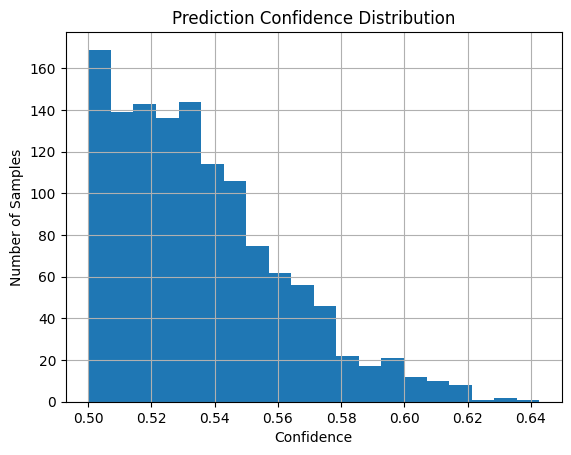

In [22]:
plt.hist(confidences, bins=20)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

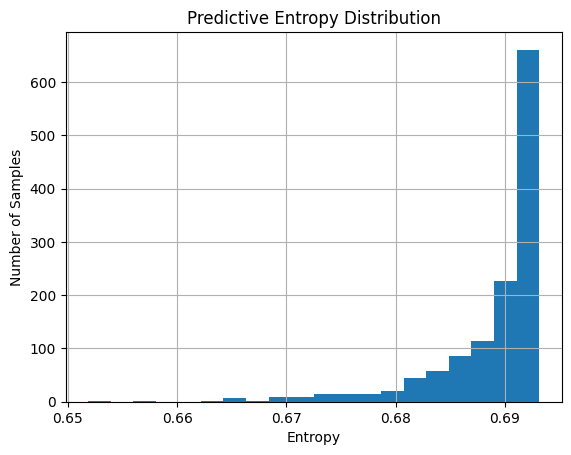

In [23]:
plt.hist(entropies, bins=20)
plt.title("Predictive Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

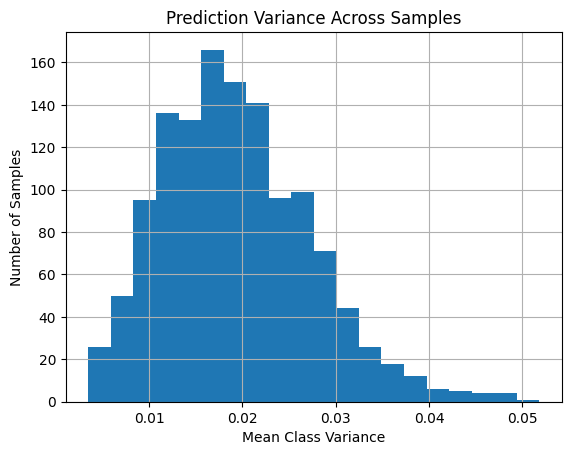

In [24]:
plt.hist(variances, bins=20)
plt.title("Prediction Variance Across Samples")
plt.xlabel("Mean Class Variance")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

# Deterministic Classifier

In [25]:
class DeterministicClassifier(nn.Module):
    def __init__(self, bert_dim, meta_dim, hidden_dim, output_dim):
        super().__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        for p in self.bert_model.parameters():
            p.requires_grad = False
        self.bert_model.eval()

        self.fc1 = nn.Linear(bert_dim + meta_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids, attention_mask, metadata):
        with torch.no_grad():
            bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        x = torch.cat((bert_output, metadata), dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [26]:
model = DeterministicClassifier(768, meta_dim, 128, 6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def train_epoch_det(dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])
        loss = loss_fn(logits, batch['label'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [27]:
batch = next(iter(train_loader))

model.eval()

with torch.no_grad():
    logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, batch['label'])

print(f" Deterministic model loss (single batch): {loss.item():.4f}")



 Deterministic model loss (single batch): 1.7005


## Traning Loop

In [28]:
num_epochs = 3
for epoch in range(num_epochs):
    avg_loss = train_epoch_det(train_loader)
    print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}")


Epoch 1 Completed - Avg Loss: 0.6463
Epoch 2 Completed - Avg Loss: 0.6216
Epoch 3 Completed - Avg Loss: 0.6150


## Evaluation

In [29]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1


In [30]:
acc, f1 = evaluate(model, valid_loader)
print(f"Deterministic Validation Accuracy: {acc:.4f}")
print(f"Deterministic Validation Macro F1: {f1:.4f}")


Deterministic Validation Accuracy: 0.6861
Deterministic Validation Macro F1: 0.5828
